In [15]:
import torch
from torch import Tensor
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
import torch.optim as optim
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'

In [2]:
seed = 123
torch.manual_seed(seed)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_set = MNIST("../datasets", train=True, download=True, transform=transforms.ToTensor())
test_set = MNIST("../datasets", train=False, download=True, transform=transforms.ToTensor())
train_set.data.shape, test_set.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

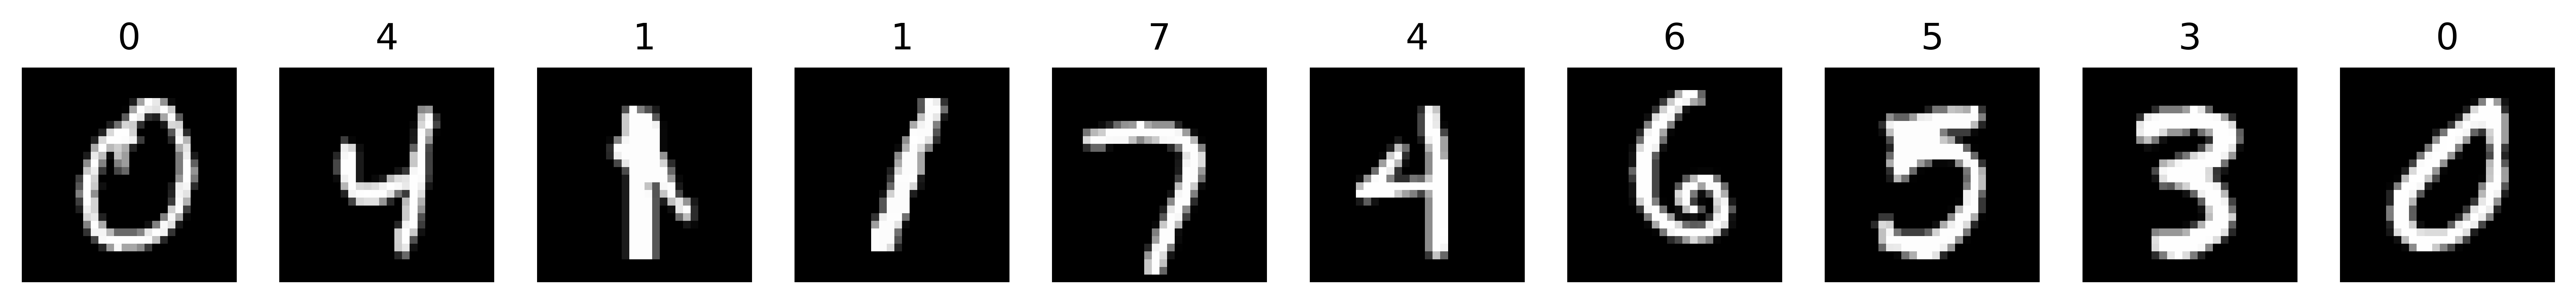

In [4]:
fig, axis = plt.subplots(1, 10, figsize=(15, 5), dpi=600)

for ax in axis:
    idx = np.random.randint(0, len(train_set))
    img = train_set.data[idx]
    label = train_set.targets[idx]
    ax.imshow(img, cmap="gray")
    ax.set_title(label.item())
    ax.axis("off")

plt.show()

In [5]:
BATCH_SIZE = 32
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

In [6]:
class CVAE(nn.Module):
    def __init__(self, input_dim, class_size, hidden_dim=200, z_dim=20) -> None:
        super(CVAE, self).__init__()

        self.class_size = class_size

        # encoder
        self.img_2hid = nn.Linear(input_dim + self.class_size, hidden_dim)
        self.hid_2mu = nn.Linear(hidden_dim, z_dim)
        self.hid_2sigma = nn.Linear(hidden_dim, z_dim)

        # decoder
        self.z_2hid = nn.Linear(z_dim + self.class_size, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    # input img -> Hidden dim -> mean, std -> Parametrization trick -> Decoder -> output
    def encode(self, x: Tensor, c: Tensor):
        input = torch.cat([x, c], dim=1)
        x = self.relu(self.img_2hid(input))
        mu, sigma = self.hid_2mu(x), self.hid_2sigma(x)
        return mu, sigma

    def decode(self, x: Tensor, c:Tensor):
        input = torch.cat([x, c], dim=1)
        x = self.relu(self.z_2hid(input))
        x = self.hid_2img(x)
        return self.sigmoid(x)
    
    def forward(self, x:Tensor, c:Tensor):
        mu, sigma = self.encode(x, c)
        eps = torch.randn_like(sigma)
        z_reparametrizes = mu + sigma * eps
        x_reconstructed = self.decode(z_reparametrizes, c)

        return x_reconstructed, mu, sigma

In [7]:
model = CVAE(input_dim= 28 * 28, class_size=10).to(DEVICE)
# model.load_state_dict(torch.load("./best_model.pth", weights_only=True))

In [100]:
NUM_EPOCH = 50
LEARNING_RATE = 1e-3

criterion = nn.BCELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# optimizer.load_state_dict(torch.load("./optimizer_states.pth", weights_only=True))

In [101]:
min_loss = float('inf')
train_loss = []

for epoch in range(NUM_EPOCH):

    total_loss = 0

    for img, label in tqdm(train_loader, desc=f'Epoch: {epoch + 1}'):
        img, label = img.view(-1, 1 * 28 * 28).to(DEVICE), label.to(DEVICE)
        encoded_label = nn.functional.one_hot(label, 10)
        x_reconstructed, mu, sigma = model(img, encoded_label)

        kl_divergance = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
        loss = criterion(x_reconstructed, img) + kl_divergance

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / BATCH_SIZE
    train_loss.append(epoch_loss)
    print(f'Epoch: {epoch + 1} | Loss: {epoch_loss:.4f}')

    if epoch_loss < min_loss:
        torch.save(model.state_dict(), "./best_model.pth")
        torch.save(optimizer.state_dict(), "./optimizer_states.pth")
        min_loss = epoch_loss

Epoch: 1: 100%|██████████| 1875/1875 [00:09<00:00, 198.08it/s]


Epoch: 1 | Loss: 218157.0641


Epoch: 2: 100%|██████████| 1875/1875 [00:09<00:00, 203.31it/s]


Epoch: 2 | Loss: 218061.6814


Epoch: 3: 100%|██████████| 1875/1875 [00:09<00:00, 207.75it/s]


Epoch: 3 | Loss: 218044.3249


Epoch: 4: 100%|██████████| 1875/1875 [00:09<00:00, 204.23it/s]


Epoch: 4 | Loss: 217911.7287


Epoch: 5: 100%|██████████| 1875/1875 [00:08<00:00, 208.97it/s]


Epoch: 5 | Loss: 217844.7229


Epoch: 6: 100%|██████████| 1875/1875 [00:09<00:00, 206.25it/s]


Epoch: 6 | Loss: 217780.5019


Epoch: 7: 100%|██████████| 1875/1875 [00:09<00:00, 198.54it/s]


Epoch: 7 | Loss: 217678.5067


Epoch: 8: 100%|██████████| 1875/1875 [00:09<00:00, 195.02it/s]


Epoch: 8 | Loss: 217708.1221


Epoch: 9: 100%|██████████| 1875/1875 [00:09<00:00, 201.40it/s]


Epoch: 9 | Loss: 217549.7803


Epoch: 10: 100%|██████████| 1875/1875 [00:09<00:00, 198.35it/s]


Epoch: 10 | Loss: 217556.0913


Epoch: 11: 100%|██████████| 1875/1875 [00:09<00:00, 206.18it/s]


Epoch: 11 | Loss: 217497.0224


Epoch: 12: 100%|██████████| 1875/1875 [00:09<00:00, 197.37it/s]


Epoch: 12 | Loss: 217359.3337


Epoch: 13: 100%|██████████| 1875/1875 [00:09<00:00, 199.53it/s]


Epoch: 13 | Loss: 217365.3957


Epoch: 14: 100%|██████████| 1875/1875 [00:09<00:00, 204.22it/s]


Epoch: 14 | Loss: 217305.9591


Epoch: 15: 100%|██████████| 1875/1875 [00:09<00:00, 207.66it/s]


Epoch: 15 | Loss: 217222.2656


Epoch: 16: 100%|██████████| 1875/1875 [00:09<00:00, 206.88it/s]


Epoch: 16 | Loss: 217258.3090


Epoch: 17: 100%|██████████| 1875/1875 [00:09<00:00, 205.94it/s]


Epoch: 17 | Loss: 217157.4281


Epoch: 18: 100%|██████████| 1875/1875 [00:09<00:00, 205.26it/s]


Epoch: 18 | Loss: 217063.0684


Epoch: 19: 100%|██████████| 1875/1875 [00:09<00:00, 201.06it/s]


Epoch: 19 | Loss: 217155.0640


Epoch: 20: 100%|██████████| 1875/1875 [00:09<00:00, 201.27it/s]


Epoch: 20 | Loss: 216934.9115


Epoch: 21: 100%|██████████| 1875/1875 [00:09<00:00, 203.59it/s]


Epoch: 21 | Loss: 216908.2529


Epoch: 22: 100%|██████████| 1875/1875 [00:09<00:00, 204.04it/s]


Epoch: 22 | Loss: 216819.2062


Epoch: 23: 100%|██████████| 1875/1875 [00:09<00:00, 201.04it/s]


Epoch: 23 | Loss: 216848.5783


Epoch: 24: 100%|██████████| 1875/1875 [00:09<00:00, 205.21it/s]


Epoch: 24 | Loss: 216801.2473


Epoch: 25: 100%|██████████| 1875/1875 [00:09<00:00, 197.48it/s]


Epoch: 25 | Loss: 216704.6859


Epoch: 26: 100%|██████████| 1875/1875 [00:09<00:00, 204.14it/s]


Epoch: 26 | Loss: 216730.5990


Epoch: 27: 100%|██████████| 1875/1875 [00:09<00:00, 207.79it/s]


Epoch: 27 | Loss: 216529.2729


Epoch: 28: 100%|██████████| 1875/1875 [00:08<00:00, 209.86it/s]


Epoch: 28 | Loss: 216641.9760


Epoch: 29: 100%|██████████| 1875/1875 [00:09<00:00, 206.50it/s]


Epoch: 29 | Loss: 216463.9739


Epoch: 30: 100%|██████████| 1875/1875 [00:09<00:00, 204.55it/s]


Epoch: 30 | Loss: 216488.0749


Epoch: 31: 100%|██████████| 1875/1875 [00:08<00:00, 208.53it/s]


Epoch: 31 | Loss: 216387.7923


Epoch: 32: 100%|██████████| 1875/1875 [00:09<00:00, 205.79it/s]


Epoch: 32 | Loss: 216485.9456


Epoch: 33: 100%|██████████| 1875/1875 [00:09<00:00, 206.24it/s]


Epoch: 33 | Loss: 216392.2415


Epoch: 34: 100%|██████████| 1875/1875 [00:09<00:00, 203.38it/s]


Epoch: 34 | Loss: 216197.4701


Epoch: 35: 100%|██████████| 1875/1875 [00:09<00:00, 204.12it/s]


Epoch: 35 | Loss: 216288.1728


Epoch: 36: 100%|██████████| 1875/1875 [00:09<00:00, 202.62it/s]


Epoch: 36 | Loss: 216135.3491


Epoch: 37: 100%|██████████| 1875/1875 [00:09<00:00, 203.03it/s]


Epoch: 37 | Loss: 216071.7278


Epoch: 38: 100%|██████████| 1875/1875 [00:09<00:00, 203.86it/s]


Epoch: 38 | Loss: 216124.2354


Epoch: 39: 100%|██████████| 1875/1875 [00:09<00:00, 193.17it/s]


Epoch: 39 | Loss: 216019.6950


Epoch: 40: 100%|██████████| 1875/1875 [00:09<00:00, 196.76it/s]


Epoch: 40 | Loss: 216012.8160


Epoch: 41: 100%|██████████| 1875/1875 [00:09<00:00, 197.39it/s]


Epoch: 41 | Loss: 215928.8072


Epoch: 42: 100%|██████████| 1875/1875 [00:09<00:00, 205.06it/s]


Epoch: 42 | Loss: 215800.1524


Epoch: 43: 100%|██████████| 1875/1875 [00:09<00:00, 208.21it/s]


Epoch: 43 | Loss: 215914.4599


Epoch: 44: 100%|██████████| 1875/1875 [00:09<00:00, 202.81it/s]


Epoch: 44 | Loss: 215756.8867


Epoch: 45: 100%|██████████| 1875/1875 [00:09<00:00, 200.78it/s]


Epoch: 45 | Loss: 215840.3338


Epoch: 46: 100%|██████████| 1875/1875 [00:09<00:00, 199.26it/s]


Epoch: 46 | Loss: 215800.2557


Epoch: 47: 100%|██████████| 1875/1875 [00:09<00:00, 201.77it/s]


Epoch: 47 | Loss: 215665.3115


Epoch: 48: 100%|██████████| 1875/1875 [00:09<00:00, 207.36it/s]


Epoch: 48 | Loss: 215554.8475


Epoch: 49: 100%|██████████| 1875/1875 [00:09<00:00, 205.44it/s]


Epoch: 49 | Loss: 215641.9206


Epoch: 50: 100%|██████████| 1875/1875 [00:09<00:00, 206.92it/s]

Epoch: 50 | Loss: 215529.9749


In [102]:
model.load_state_dict(torch.load("./best_model.pth", weights_only=True))

<All keys matched successfully>

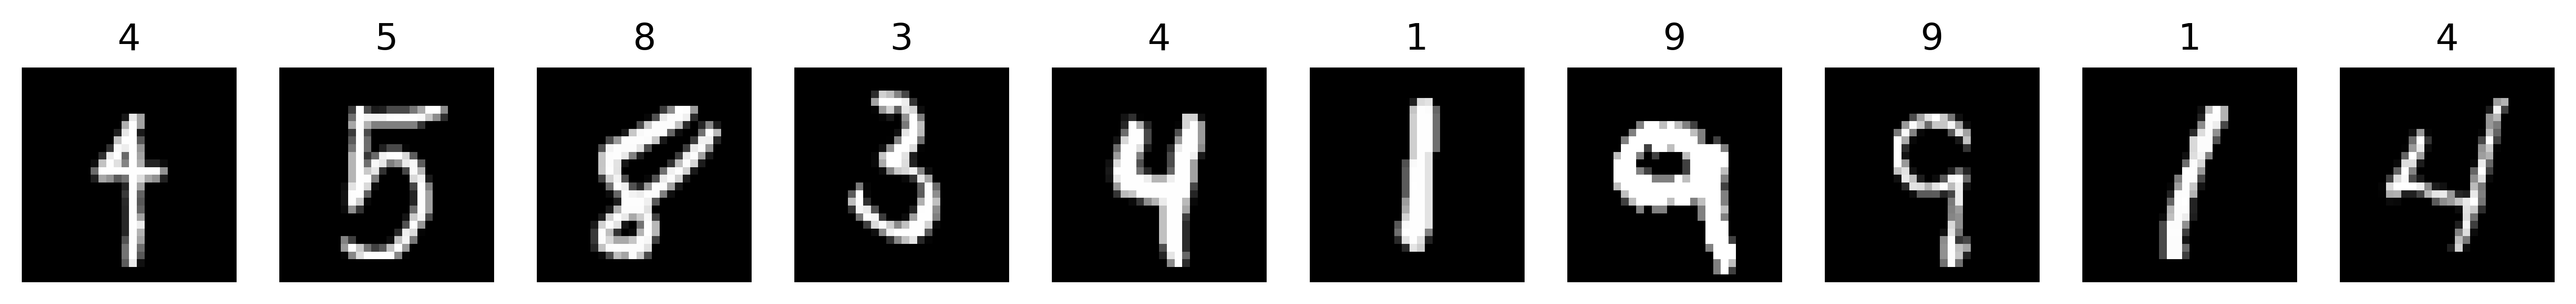

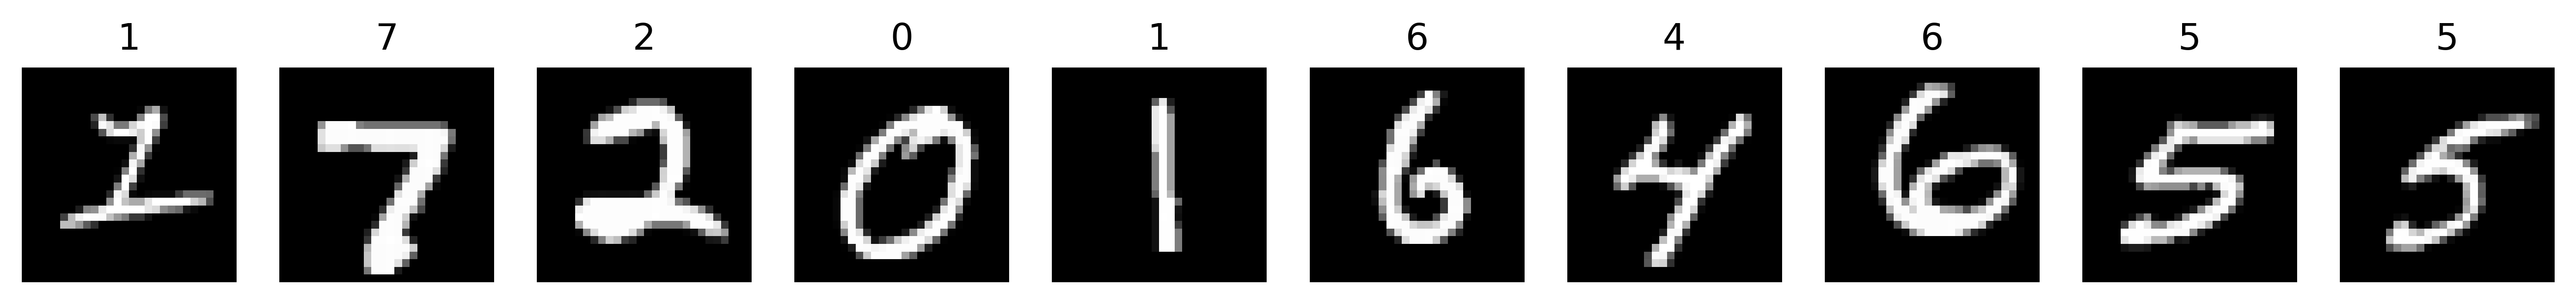

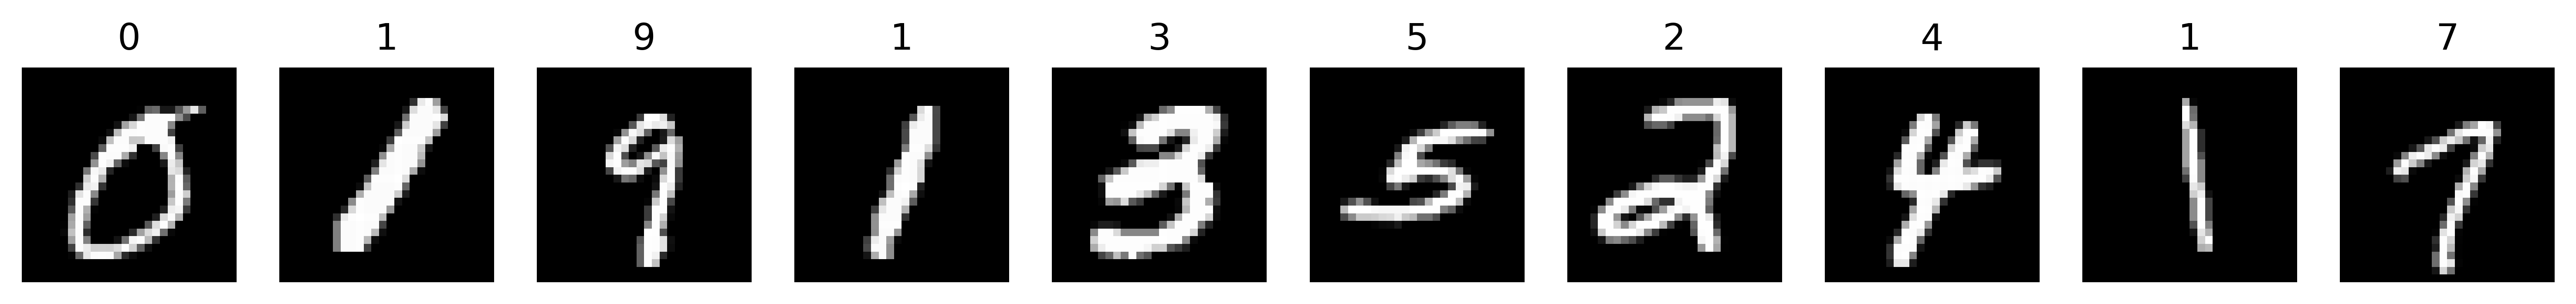

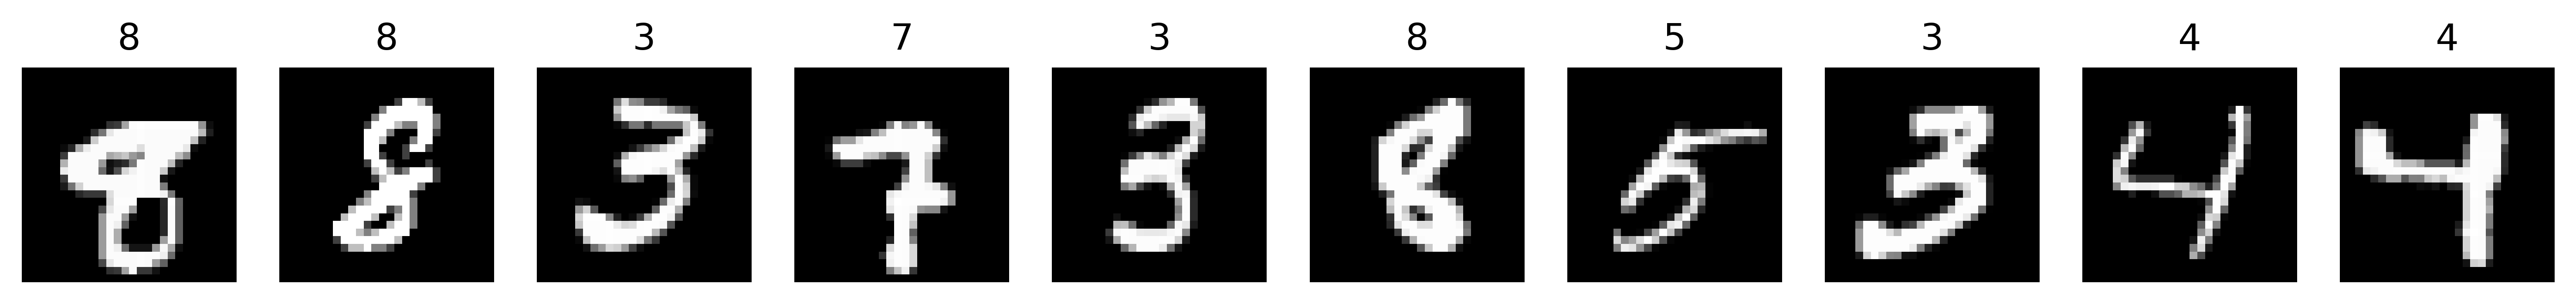

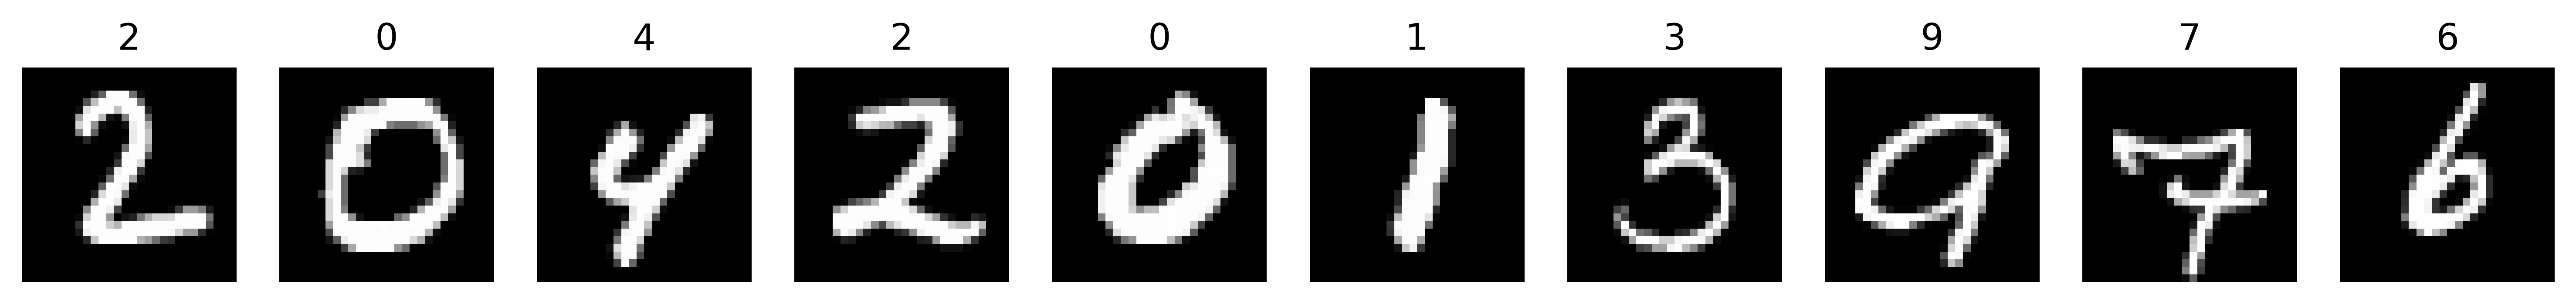

In [103]:
with torch.no_grad():
    for i, (input, label) in enumerate(test_loader, start=1):
        input, label = input.view(-1, 28 * 28).to(DEVICE), label.to(DEVICE)
        encoded_label = nn.functional.one_hot(torch.ones_like(label) * 4, 10)
        out, mu, sigma = model(input, encoded_label)
        
        fig, axis = plt.subplots(1, 10, figsize=(15, 5), dpi=500)
        for img, ax in zip(out, axis):
            img = img.cpu().view(28, 28)
            idx = np.random.randint(0, len(train_set))
            img = train_set.data[idx]
            label = train_set.targets[idx]
            ax.imshow(img, cmap="gray")
            ax.set_title(label.item())
            ax.axis("off")
        plt.show()
        # plt.savefig(f'./generated_images/fig_{i}.png')

        if i == 5:
            break

In [104]:
def generate_image(class_label):
    
    z_dim = 20
    z = torch.randn(1, z_dim).to(DEVICE)

    class_vector = nn.functional.one_hot(torch.tensor(class_label), num_classes=10).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        generated_image = model.decode(z, class_vector)

    generated_image = generated_image.cpu().view(28, 28)
    return generated_image

## Generating new images

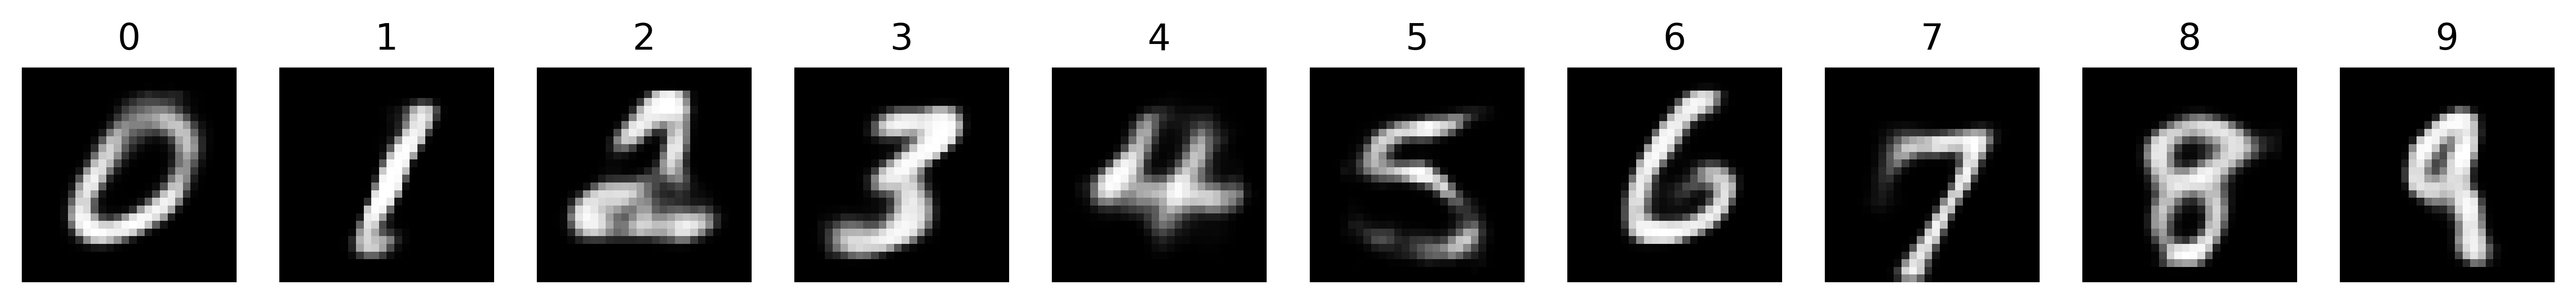

In [114]:
fig, axis = plt.subplots(1, 10, figsize=(15, 5), dpi=500)
for i, ax in enumerate(axis):
    generated_img = generate_image(i)
    ax.imshow(generated_img, cmap="gray")
    ax.axis("off")
    ax.set_title(i)

plt.show()

In [12]:
latent_vectors = []
labels = []

with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = images.view(-1, 1 * 28 * 28).to(DEVICE)
        class_vector = nn.functional.one_hot(targets, num_classes=10).to(DEVICE) 
        x_reconstructed, mu, sigma = model(images, class_vector)            
        latent_vectors.extend(mu.cpu())
        labels.extend(targets)

100%|██████████| 1000/1000 [00:01<00:00, 597.37it/s]


In [16]:
latent_2d = TSNE(n_components=2).fit_transform(np.array(latent_vectors))

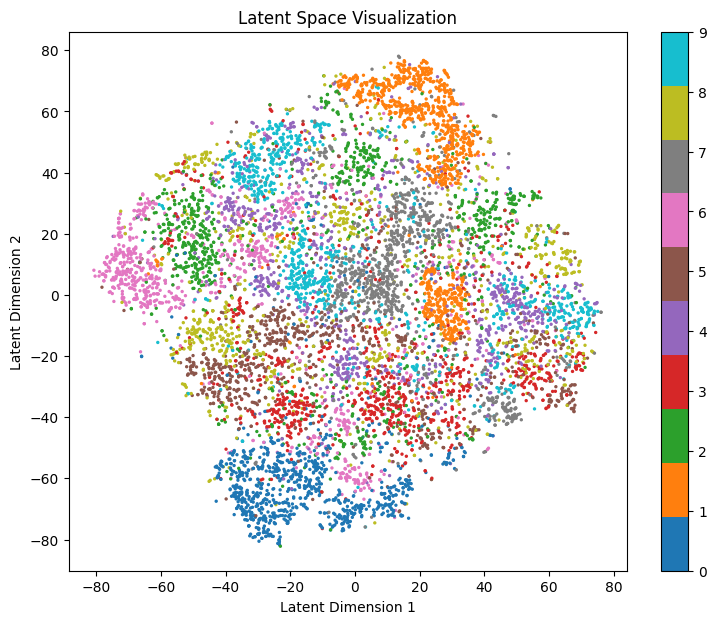

In [18]:
plt.figure(figsize=(9, 7))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar()
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()